![CAO Logo](https://upload.wikimedia.org/wikipedia/commons/5/51/Central_Applications_Office.png)

# CAO Points Analysis

This notebook demonstrates how to gather and analyse CAO points data for level 8 courses over the last three years.

The first part will discuss the various formats in which the points data is stored on the CAO website, and how to download these from the website using Python. Additionally, guidelines will be given on converting the points data to Pandas dataframes, which can then be used for further analysis.

The second part will discuss the analysis that was performed on the resulting Pandas dataframes, with a particular focus on the following techniques:

1. Merging the three distinct dataframes together for analysis on the full dataset
2. Changing the shape of the dataset to get all three years on the same column for Seaborn plots
3. Sorting/grouping the dataset to find maximum and minimum values for variables (e.g. course type)

## Research Questions

The following research questions will be used to organize the findings:

1. What is the overall distribution of level 8 points values, and how has this changed over the past three years?
2. What are the most popular areas of study (i.e. the areas in which the most courses are offered), and have points increased or decreased for these over the past three years?
3. How does the distribution of points differ between Universities and Institutes of Technology (ITs)?
4. What were the highest/lowest point courses each year?
5. For the highest/lowest points of 2019, did these increase or decrease in popularity in 2020/21?

This notebook will present the code required to answer these questions, the resulting data/plots, and discuss the results.

## Part 1: Points Data

### 2021

The 2021 points data is stored as a webpage at the below address:

http://www2.cao.ie/points/l8.php

In order to convert this data into a format compatible with the Pandas dataframe, the following steps are required:

1. Retrieve the data
2. Back up the data as of the current/date and time and save it as a html file
3. Create a regex pattern to detect course/points information only and filter out unnecessary detail
4. Write all lines of the original webpage that match the regex statement to a CSV file
5. Convert the compiled points data to a Pandas dataframe
6. Change the R1/R2 points columns to numeric to facilitate further analysis. 

#### Part 1: Retrieve and Back Up Data

The CAO course data for 2021 was, at the time I started this project, available only in HTML format on the CAO website. In November the data was made available in an Excel format. However I have decided to keep the HTML format in this notebook to illustrate how data can be converted directly from a website to a format compatible with Pandas.

The data is obtained from the CAO website using the requests module, which allows you to send a HTTP request to a webpage. The HTTP request then returns a **response** object, which contains the content, encoding and status of the webpage.

The webpage content must then be backed up at the time/date the HTTP request was made. This is done by constructing a filepath including the current system date and time, and writing the text contents to a HTML file. 

Note that an encoding parameter must be passed to convert the webpage data to readable text. According to the web server, the character set used to encode this website is ISO 8859-1 (as seen in below code), this cannot be used as the encoding parameter due to one character that is incompatible with this standard.

In [5]:
import re
import urllib
import requests as rq
import datetime as dt
import os
import pandas as pd
from urllib.request import urlopen

response = urlopen('http://www2.cao.ie/points/l8.php')
charset = response.headers.get_content_charset()
print(charset)

iso-8859-1


Instead, the CP1252 standard must be used to decode the webpage, as this supports the character (x96) that is not compatible with ISO 8859-1.

The code to decode and back up the data is given below. 

In [6]:
#Getting current date and time so unique, up to date version of site is saved each time code is run
#Note that underscores are being used instead of slashes, as slashes will cause issues when generating the file path

timenow = dt.datetime.now()
nowstrng = timenow.strftime('%Y%m%d_%H%M%S')

#Getting current directory to pass to filepath variable
currentpath = os.getcwd()

#Getting data from CAO site
resp = rq.get('http://www2.cao.ie/points/l8.php')

#Constructing filepath
filepath  = currentpath + '\\' + 'Points_Data'+ '\\' + 'cao2021'+ nowstrng + '.html'
csvfilepath = currentpath + '\\' +'Points_Data'+ '\\'+ 'cao2021' + nowstrng + '.csv'

#Changing encoding from iso-8859-1 to cp1252, one line uses an x96 character (-) which is not supported in iso-8859-1. 
#If encoding is not changed the file won't be decoded
original_encoding = resp.encoding
resp.encoding = 'cp1252'

#Writing html text to file so original format is stored on repository
with open(filepath, "w") as f:
    f.write(resp.text)

print("Data saved to {}".format(filepath))

Data saved to C:\Users\Owner\Desktop\Fundamentals-of-Data-Analysis-21-Assessment\Points_Data\cao202120211229_141721.html


Below is a screenshot showing the format of the data on the CAO website.

##### Figure 1: CAO Website Points 2021

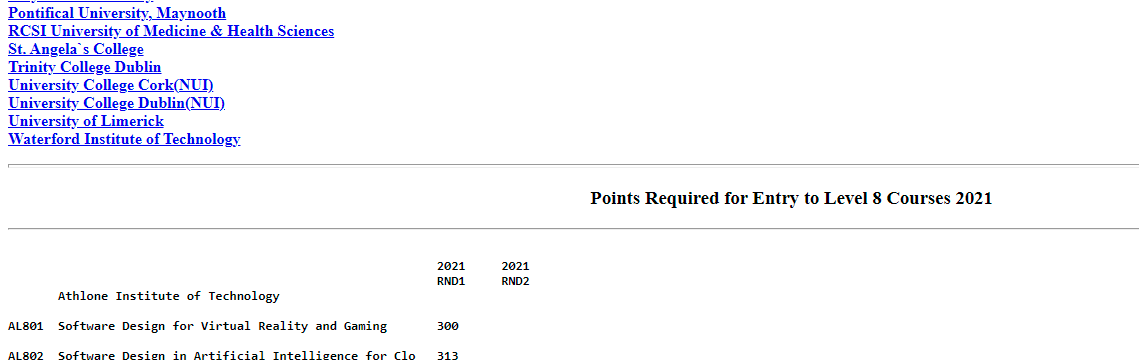

As seen in the screenshot, several elements of the webpage are not required for our purposes, such as the title and links to certain areas of the page.

We can also see that the points data follows a specific format. First, the course code is listed, then the name, then the Round 1 and 2 points for that course. Therefore, constructing a regex statement that captures data in this format and applying it to all lines in the webpage should allow us to only extract 

